In [6]:
%pip install scikit-learn
%pip install psutil

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Binary classification on kdd99 corrected.csv

In [73]:
import pandas as pd
from sklearn.decomposition import PCA
from time import time
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('dark_background')
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import warnings; warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [74]:
#loading the data
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", 
             "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", 
             "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", 
             "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
             "srv_diff_host_rate", "dst_host_count","dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
             "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
             "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

#Initially, we will use all features
num_features = ["duration", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", 
                "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
                "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", 
                "srv_serror_rate", "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate", 
                "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
                "dst_host_rerror_rate", "dst_host_srv_rerror_rate"]

kdd_df = pd.read_csv("../KDD99/corrected.csv", names = col_names)
kdd_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,311029.000000,3.110290e+05,3.110290e+05,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,...,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000
mean,17.902736,1.731702e+03,7.479937e+02,0.000029,0.000762,0.000051,0.014677,0.002363,0.172476,0.011243,...,235.282681,199.193914,0.793494,0.024953,0.547919,0.004566,0.058764,0.058791,0.142659,0.141693
std,407.644400,1.276567e+05,1.612018e+04,0.005379,0.040367,0.009821,0.312068,0.049990,0.377794,1.958325,...,60.913298,100.306470,0.387090,0.096003,0.491963,0.035773,0.231296,0.232997,0.344380,0.346573
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.050000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,244.000000,0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,57715.000000,6.282565e+07,5.203179e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [75]:
features = kdd_df[num_features].astype(float)
features.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,311029.000000,3.110290e+05,3.110290e+05,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,...,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000
mean,17.902736,1.731702e+03,7.479937e+02,0.000029,0.000762,0.000051,0.014677,0.002363,0.172476,0.011243,...,235.282681,199.193914,0.793494,0.024953,0.547919,0.004566,0.058764,0.058791,0.142659,0.141693
std,407.644400,1.276567e+05,1.612018e+04,0.005379,0.040367,0.009821,0.312068,0.049990,0.377794,1.958325,...,60.913298,100.306470,0.387090,0.096003,0.491963,0.035773,0.231296,0.232997,0.344380,0.346573
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.050000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,244.000000,0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,57715.000000,6.282565e+07,5.203179e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [76]:
#we are going to reduce the outputs to 'normal' and 'attack'
labels = kdd_df['label'].copy()
labels_binary = kdd_df['label'].copy()
labels_binary[labels_binary != 'normal.'] = 'attack.'
val_count = labels_binary.value_counts()

In [77]:
## GET ALL INFORMATION HERE
print(len(kdd_df))
print(len(kdd_df.columns))

print(val_count[1]/val_count[0])

311029
42
0.24195003913175422


In [78]:
# Assuming 'features' is your DataFrame
scaler = MinMaxScaler()

# Apply Min-Max scaling to each column separately
features_scaled = features.copy()
for column in features.columns:
    column_data = features[column].values.reshape(-1, 1)
    features_scaled[column] = scaler.fit_transform(column_data)

# If you want to keep the scaled data in the original DataFrame
features_scaled.columns = features.columns
features_scaled.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,...,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000,311029.000000
mean,0.000310,0.000028,0.000144,0.000029,0.000254,0.000017,0.000145,0.000591,0.172476,0.000014,...,0.922677,0.781153,0.793494,0.024953,0.547919,0.004566,0.058764,0.058791,0.142659,0.141693
std,0.007063,0.002032,0.003098,0.005379,0.013456,0.003274,0.003090,0.012498,0.377794,0.002460,...,0.238876,0.393359,0.387090,0.096003,0.491963,0.035773,0.231296,0.232997,0.344380,0.346573
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.956863,0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000016,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels_binary, test_size=0.2, random_state=42)

In [14]:
#Training a classifier
#clf = RandomForestClassifier(n_estimators=optimal_n_trees, max_depth=optimal_max_depth, random_state = 0)
clf = RandomForestClassifier(random_state = 69)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

Classifier trained in 11.596 seconds.


In [15]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Classifier predicted on train set in 0.924 seconds.
Classifier predicted on test set in 0.226 seconds.
Accuracy train:  0.9815370765564276
Accuracy test:  0.981287978651577
Precision:  0.981287978651577
Recall:  0.981287978651577
F1 Score:  0.981287978651577


# Non-binary classification

In [16]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [17]:
#Training a classifier
#clf = RandomForestClassifier(n_estimators=optimal_n_trees, max_depth=optimal_max_depth, random_state=0)
clf = RandomForestClassifier(random_state=0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

Classifier trained in 12.28 seconds.


In [18]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Classifier predicted on train set in 3.062 seconds.
Classifier predicted on test set in 0.593 seconds.
Accuracy train:  0.9815169819510254
Accuracy test:  0.9810468443558499
Precision:  0.9810468443558499
Recall:  0.9810468443558499
F1 Score:  0.9810468443558499


# Select n best features based on RF feature importance

Selected features: ['srv_count', 'src_bytes', 'dst_host_same_src_port_rate', 'count', 'dst_host_same_srv_rate', 'diff_srv_rate', 'dst_bytes', 'same_srv_rate', 'dst_host_srv_count', 'dst_host_diff_srv_rate', 'logged_in', 'dst_host_rerror_rate', 'duration', 'dst_host_srv_rerror_rate', 'rerror_rate', 'dst_host_count']


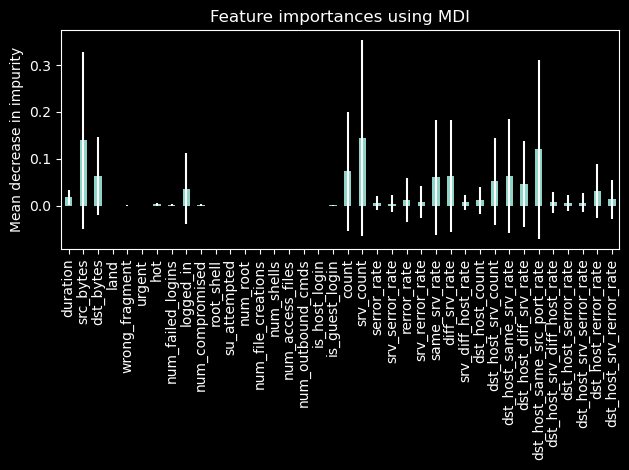

In [19]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


# Create a DataFrame with feature names and importances
feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': importances})

# Sort the DataFrame by importance scores in descending order
feature_importance_df_sorted = feature_importance_df.sort_values(by='Importance', ascending=False)

def select_important_features(feature_importance_df_sorted, threshold=0.01):
    important_features = feature_importance_df_sorted[feature_importance_df_sorted['Importance'] > threshold]
    selected_feature_names = important_features['Feature'].tolist()
    return selected_feature_names

# Usage:
selected_features = select_important_features(feature_importance_df_sorted, threshold=0.01)
print("Selected features:", selected_features)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled[selected_features], labels_binary, test_size=0.2, random_state=42)

In [21]:
#Training a classifier
#clf = RandomForestClassifier(n_estimators=optimal_n_trees, max_depth=optimal_max_depth, random_state = 0)
clf = RandomForestClassifier(random_state = 69)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Classifier trained in {} seconds.".format(round(tt, 3)))

Classifier trained in 11.605 seconds.


In [22]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

Classifier predicted on train set in 0.812 seconds.
Classifier predicted on test set in 0.206 seconds.
Accuracy train:  0.9815330576353473
Accuracy test:  0.9811111468347105
Precision:  0.9811111468347105
Recall:  0.9811111468347105
F1 Score:  0.9811111468347105


# PCA to find the optimal number of principal components and getting accuracy

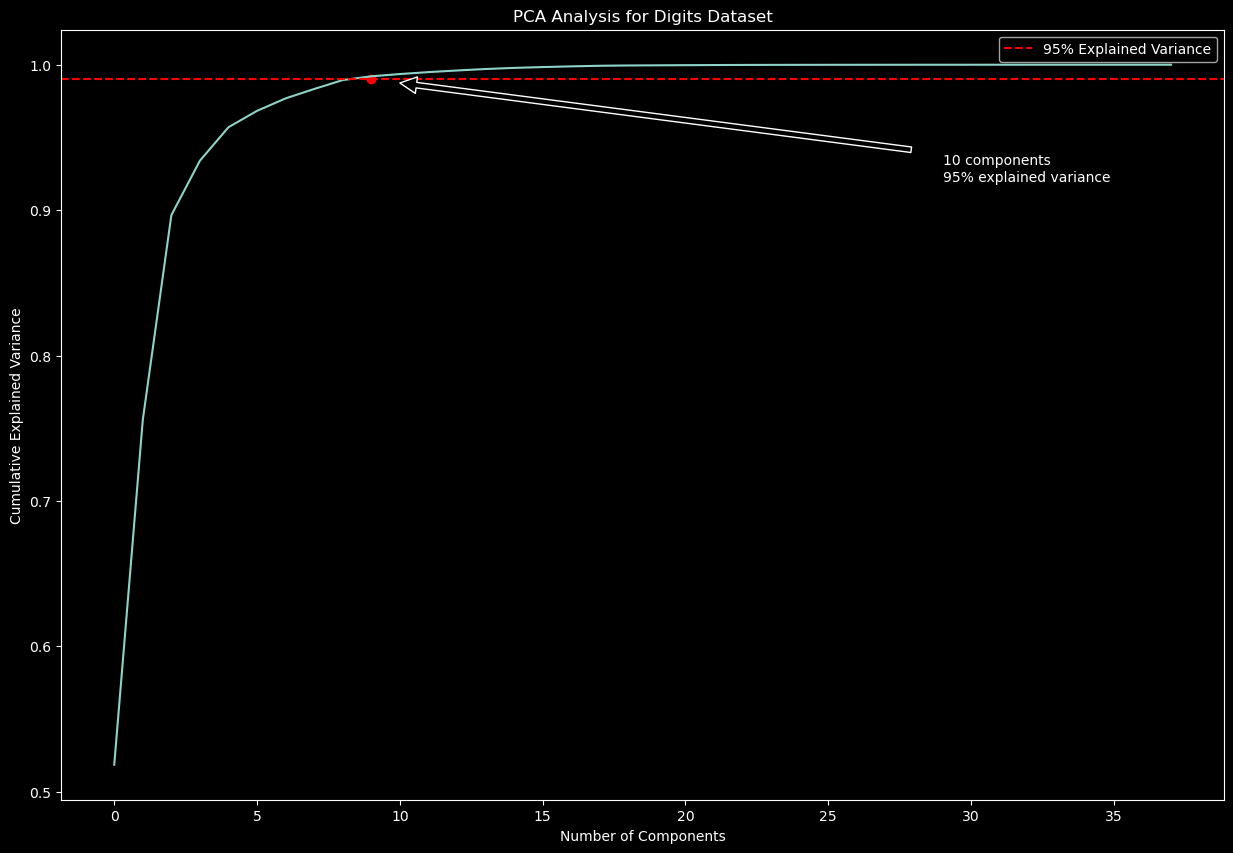

In [68]:
pca = PCA(whiten=True).fit(features_scaled)

fig, ax = plt.subplots( figsize=(15, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Analysis for Digits Dataset')
plt.axhline(y=0.99, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()

# Find the index where cumulative explained variance first exceeds 95%
index_95_percent = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.99)

# Add a marker at the 95% point
plt.scatter(index_95_percent, 0.99, color='r', marker='o')

# Annotate the point with text
plt.annotate(f'{index_95_percent+1} components\n95% explained variance',
             xy=(index_95_percent, 0.99), xytext=(index_95_percent+20, 0.92),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()
index_95_percent = index_95_percent +1

In [69]:
pca = PCA(n_components=index_95_percent, whiten=True)
pca_result = pca.fit_transform(features_scaled)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(pca_result, labels, test_size=0.2, random_state=42)

In [71]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

Trained in 27.288 seconds


In [72]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Optimal number of components: ", index_95_percent)

Classifier predicted on train set in 2.771 seconds.
Classifier predicted on test set in 0.553 seconds.
Accuracy train:  0.9758221707800324
Accuracy test:  0.9735877568080249
Precision:  0.9735877568080249
Recall:  0.9735877568080249
F1 Score:  0.9735877568080249
Optimal number of components:  10


# Selecting the best features

In [34]:
# Create a LabelEncoder instance
label_encoder = LabelEncoder()

encoded_labels = labels.copy()
encoded_binary_labels = labels_binary.copy()

# Fit the encoder on the labels and transform the column
encoded_labels = label_encoder.fit_transform(encoded_labels)
encoded_binary_labels = label_encoder.fit_transform(encoded_binary_labels)

combined_df = pd.concat([df1, df2], ignore_index=True)


NameError: name 'df1' is not defined

In [ ]:
# Define a list of percentiles to test
percentiles = [10, 15, 20, 25, 30]

# Create a pipeline with feature selection and your classifier
model = make_pipeline(SelectPercentile(score_func=f_classif), RandomForestClassifier())

# Store accuracies for each percentile
accuracies = []

# Perform cross-validation for each percentile
for percentile in tqdm(percentiles):
    model.set_params(selectpercentile__percentile=percentile)
    scores = cross_val_score(model, features_scaled, labels, cv=5)
    accuracies.append(scores.mean())

# Print accuracies for each percentile
for percentile, accuracy in zip(percentiles, accuracies):
    print(f"Percentile: {percentile}, Mean Accuracy: {accuracy}")



# Initialize variables to store the optimal percentile and accuracy
optimal_percentile = None
optimal_accuracy = None

# Iterate through the percentiles and accuracies
for i in range(len(percentiles) - 1):
    gap_accuracy = accuracies[i+1] - accuracies[i]
    if gap_accuracy < 0.5:
        optimal_percentile = percentiles[i]
        optimal_accuracy = accuracies[i]
        break

# If no percentile meets the condition, choose the last one
if optimal_percentile is None:
    optimal_percentile = percentiles[-1]
    optimal_accuracy = accuracies[-1]

print(f"Optimal Percentile: {optimal_percentile}, Optimal Accuracy: {optimal_accuracy}")


In [19]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, encoded_labels, test_size=0.2, random_state=42)

In [20]:
selector = SelectPercentile(score_func=f_classif, percentile=optimal_percentile)

# Fit and transform the training set
X_train_selected = selector.fit_transform(X_train, y_train)

# Use the selected features to transform the test set
X_test_selected = selector.transform(X_test)

In [21]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train_selected, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

Trained in 8.814 seconds


In [22]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train_selected)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test_selected)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("% feature selected", optimal_percentile)

Classifier predicted on train set in 2.687 seconds.
Classifier predicted on test set in 0.528 seconds.
Accuracy train:  0.9371079040120889
Accuracy test:  0.9312445744783462
Precision:  0.9312445744783462
Recall:  0.9312445744783462
F1 Score:  0.9312445744783462


# Select n best features based on RFECV

In [13]:
# Select at least 10% of the features
num_columns = len(kdd_df.columns)
min_features_to_select = int(num_columns * 0.1)

clf = RandomForestClassifier()
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=2,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(features, labels)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 30


In [14]:
selected_feature_indices = rfecv.support_
selected_feature_names = [num_features[i] for i, selected in enumerate(selected_feature_indices) if selected]

print("Selected Features:", selected_feature_names)

reduced_df = features[selected_feature_names]

Selected Features: ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'num_root', 'num_file_creations', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']


In [18]:
# Fit and transform the training set
X_train, X_test, y_train, y_test = train_test_split(reduced_df, labels, test_size=0.2, random_state=42)

In [19]:
#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

Trained in 13.889 seconds


In [22]:
# Prediction on train set
t0 = time()
pred_train = clf.predict(X_train)
tt = time() - t0
print ("Classifier predicted on train set in {} seconds.".format(round(tt, 3)))

# Prediction on test set
t0 = time()
pred_test = clf.predict(X_test)
tt = time() - t0
print ("Classifier predicted on test set in {} seconds.".format(round(tt, 3)))

# Metrics
precision = precision_score(y_test, pred_test, average='micro')
recall = recall_score(y_test, pred_test, average='micro')
f1 = f1_score(y_test, pred_test, average='micro')
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)

# Printing results
print("Accuracy train: ", accuracy_train)
print("Accuracy test: ", accuracy_test)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("N features selected", len(reduced_df.columns))

Classifier predicted on train set in 7.75 seconds.
Classifier predicted on test set in 1.415 seconds.
Accuracy train:  0.9815169819510254
Accuracy test:  0.981062919975565
Precision:  0.981062919975565
Recall:  0.981062919975565
F1 Score:  0.981062919975565
N features selected 30


In [21]:
len(num_features)

38

In [84]:
import psutil
# Measure memory usage before training the model
memory_before = psutil.virtual_memory().used

#Predictions on the test data
clf = RandomForestClassifier(random_state = 0)
t0 = time()
clf.fit(X_train, y_train)
tt = time() - t0
print ("Trained in {} seconds".format(round(tt,3)))

# Measure memory usage after training the model
memory_after = psutil.virtual_memory().used

# Calculate the memory usage during the training process
memory_used = memory_after - memory_before

print(f"Memory used during training: {memory_used / 1024 / 1024:.2f} MB")

Trained in 12.016 seconds
Memory used during training: 94.74 MB


In [79]:
def get_anomaly_scores(df_original, df_restored):
    loss = np.sum((np.array(df_original) - np.array(df_restored)) ** 2, axis=1)
    loss = pd.Series(data=loss, index=df_original.index)
    return loss

In [82]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10, random_state=0)
pca_df = pd.DataFrame(pca.fit_transform(features_scaled))

df_restored = pd.DataFrame(pca.inverse_transform(pca_df), index=pca_df.index)

<Axes: >

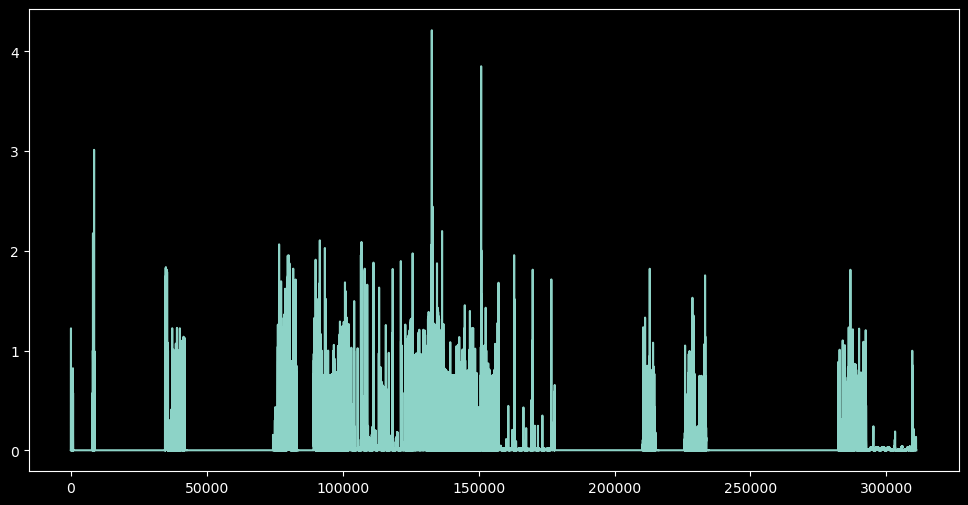

In [84]:
scores = get_anomaly_scores(features_scaled, df_restored)
scores.plot(figsize = (12, 6))